In [51]:
from __future__ import print_function
import pickle
import numpy as np
import pandas as pd
import matplotlib as mpl
try:
    import matplotlib.pyplot as plt
except:
    mpl.use("Agg")
    import matplotlib.pyplot as plt
    
import fitsio as fio    
import ngmix.medsreaders
import ngmix
import galsim
import galsim.des
import images

# Prepare DATA

## MEDS file paths

In [4]:
meds_g_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_g_meds-Y3A2_DEEP.fits.fz"
meds_r_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_r_meds-Y3A2_DEEP.fits.fz"
meds_i_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_i_meds-Y3A2_DEEP.fits.fz"

In [5]:
meds_paths = [
    meds_g_path,
    meds_r_path,
    meds_i_path,
]
mms = [ngmix.medsreaders.NGMixMEDS(path) for path in meds_paths]

## PSFex files path

In [6]:
psfex_g_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_g_psfcat.psf"
psfex_r_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_r_psfcat.psf"
psfex_i_path = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/SN-C3_C01_r3688p01/SN-C3_C01_r3688p01_i_psfcat.psf"

In [7]:
psfex_paths = [
    psfex_g_path,
    psfex_r_path,
    psfex_i_path,
]

## MOF path

In [52]:
fname = "/e/eser2/vargatn/DES/Y3_DATA/DEEP3/run-d02-SN-C3_C01_r3688p01.fits"
allmofs = fio.read(fname)

# Renderer class

In [53]:
nbands = allmofs["bdf_flux"].shape[1]

In [ ]:
pars = allmofs["bdf_pars"][0, :-nbands]

In [48]:
mms[1]["id"].byteswap().newbyteorder().dtype.byteorder

'<'

In [50]:
allmofs["id"].dtype.byteorder

'<'

In [27]:
class ComparePostage():
    _icutout = 0
    _bands = ("g", "r", "i", "z")
    def __init__(self, moftab, mms, psfex_files=None, mode="bdf"):
        """
        Currently this works in both bdf and cm
        
        It is assumed that the psf is not in the MEDS file, but is in an external psfex file
        
        Parameters:
        -----------
        moftab: record_array
            MOF rows to render
        mms: list
            list of ngmix.medsreaders.NGMixMEDS objects, one for each band
        psfex_files: list
            list of psfex file paths corresponding to each MEDS files
            
        """
        
        self.mof = moftab
        self.mms = mms
        self.psfex_files = psfex_files
        
        self.medsrow = self._get_indexarray()
        
        self.mode = mode
        if self.mode == "bdf":
            self.fluxcol = "bdf_flux"
        elif self.mode == "cm":
            self.fluxcol = "cm_flux"
        else: 
            raise KeyError("only bdf or cm mode is supported in the moment")
            
        self.nbands = self.mof[self.fluxcol].shape[1]
        
    def _get_indexarray(self):
        col1 = mof["id"]
        col2 = self.mms[0]["id"]
        
        if col
        
        imof = pd.DataFrame()
        imof["mofid"] = col1
        
        imeds = pd.DataFrame()
        imeds["medsid"] = col2
        imeds["medsrow"] = np.arange(len(col2)) 
        
        tmp = pd.merge(imof, imeds, how="inner", left_on="mofid", right_on="medsid")
        return tmp["medsrow"].values       
        
    def get_cutouts(self, iobj, iband, seg=False):
        """
        iobj should refer to the id in the mof file,
        and we should look up here which meds line it corresponds to. this is stored in self.medsrow
        """
        m = self.mms[iband]
 
        imeds = self.medsrow[iobj]
        print(imeds)
        obs_im = m.get_cutout(imeds, self._icutout)

        jac = m.get_jacobian(imeds, self._icutout)
        wcs = galsim.JacobianWCS(jac["dudcol"], jac["dudrow"], jac["dvdcol"], jac["dvdrow"])

        obs_ii = galsim.Image(obs_im, wcs=wcs)  
        
        seg_ii = None
        if seg:
            seg_ii = m.get_cutout(imeds, self._icutout, "seg") 

        orig_x = m["orig_col"][imeds, 0]
        orig_y = m["orig_row"][imeds, 0]    
        orig_pos = galsim.PositionD(orig_x, orig_y)
        des_psf = galsim.des.DES_PSFEx(self.psfex_files[iband], wcs=wcs)
        psf = des_psf.getPSF(orig_pos)    

        flux = self.mof[self.fluxcol][iobj, iband]
        band_pars = list(self.mof[self.mode + "_pars"][iobj, :-nbands])
        band_pars = np.array(band_pars + [flux,])
        
        if self.mode == "bdf":
            galmaker = ngmix.gmix.GMixBDF(band_pars)
        elif self.mode == "cm":
            galmaker = ngmix.gmix.GMixModel(band_pars, mode="cm")
            
        gal = galmaker.make_galsim_object()

        gal = galsim.Convolve(gal, psf)

        gal_ii = gal.drawImage(nx=obs_ii.array.shape[0], ny=obs_ii.array.shape[1],
                               wcs=wcs)   
        return obs_ii, gal_ii, seg_ii        
        
    def draw_postage(self, seg=False):

        for iobj in np.arange(len(self.mof)):
            g_obs, g_gal, seg_ii = self.get_cutouts(iobj, 0, seg=seg)
            r_obs, r_gal, seg_ii = self.get_cutouts(iobj, 1, seg=seg)
            i_obs, i_gal, seg_ii = self.get_cutouts(iobj, 2, seg=seg)

            mv = np.min((g_obs.array, r_obs.array, i_obs.array))
            mos_g = np.hstack([g_obs.array - mv, g_gal.array- mv, g_obs.array - g_gal.array - mv])
            mos_r = np.hstack([r_obs.array - mv, r_gal.array- mv, r_obs.array - r_gal.array - mv])
            mos_i = np.hstack([i_obs.array - mv, i_gal.array- mv, i_obs.array - i_gal.array - mv])

            factor = 0.02
            scales = np.array([1., 1., 1.3]) * factor
            nonlinear = 0.5
            clip = None        

            obs_im = images.get_color_image(mos_i, mos_r, mos_g,
                                            nonlinear=nonlinear, clip=clip, scales=scales)    

            fig, axarr = plt.subplots(ncols=1, nrows=2, figsize=(12, 6))
            fig.subplots_adjust(hspace=0.05)

            axarr[0].set_xticks([])
            axarr[0].set_yticks([])

            axarr[0].imshow(obs_im / obs_im.max())

            axarr[1].set_xticks([])
            axarr[1].set_yticks([])

            mos = mos_g + mos_r + mos_i

            mos_im = mos
            cim = axarr[1].imshow(mos_im)
            position=fig.add_axes([0.8,0.125,0.01,0.37])

            cb = fig.colorbar(cim, position)
            cb.set_label("g + r + i flux")

            fig.text(0.25, 0.9, "ID: {:d}".format(mof["id"][iobj]),
                     fontsize=16)

#             fig.savefig("stamps-6/test_"+str(iobj)+".pdf", dpi=300, bbox_inches="tight")    
#             fig.savefig("stamps-6/test_"+str(iobj)+".png", dpi=300, bbox_inches="tight")            
#             return fig, axarr

# Postage rendered

In [28]:
mof = allmofs[[10353, 7424, 9237]]
mof = allmofs[[10353,]]

In [29]:
cpost = ComparePostage(mof, mms, psfex_paths)
cpost.draw_postage()

ValueError: Big-endian buffer not supported on little-endian compiler

In [130]:
tmp = fio.read("/e/eser2/vargatn/DES/Y3_DATA/COSMOS_C01_r3766p01_mof.fits")

(array([ 757.,  228.,  312.,  683., 8311., 2987.,  154.,   79.,   68.,
         194.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

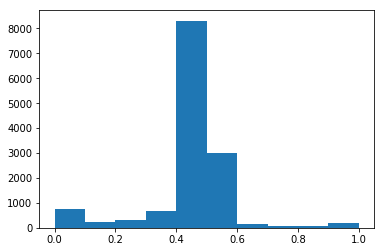

In [14]:
inds = allmofs["flags"] == 0
plt.hist(allmofs["bdf_pars"][inds, 5])

In [132]:
mof["bdf_flux"].shape

(1, 4)

In [131]:
mof["bdf_pars"][-1].shape

(10,)

In [129]:
tmp["cm_pars"][-1].shape

(9,)

In [125]:
tmp["cm_flux"]

array([[-9999.        , -9999.        , -9999.        , -9999.        ],
       [-9999.        , -9999.        , -9999.        , -9999.        ],
       [-9999.        , -9999.        , -9999.        , -9999.        ],
       ...,
       [  101.66138442,   181.18842708,   208.17364311,   192.30484706],
       [ 4127.13066122, 14833.16786719, 23692.08332877, 31529.87687425],
       [   50.49053744,    86.41434677,   142.5037418 ,   214.84054715]])

In [122]:
tmp.dtype

dtype([('id', '>i8'), ('number', '>i4'), ('ra', '>f8'), ('dec', '>f8'), ('nimage_tot', '>i4', (4,)), ('fofid', '>i8'), ('flags', '>i4'), ('time_last_fit', '>f8'), ('box_size', '>i2'), ('obj_flags', '>i4'), ('psf_flags', '>i4', (4,)), ('psf_flux', '>f8', (4,)), ('psf_flux_err', '>f8', (4,)), ('psf_mag', '>f8', (4,)), ('psf_flux_s2n', '>f8', (4,)), ('nimage_use', '>i4', (4,)), ('mask_frac', '>f8'), ('psfrec_T', '>f8'), ('psfrec_g', '>f8', (2,)), ('cm_flags', '>i4'), ('cm_pars', '>f8', (9,)), ('cm_pars_cov', '>f8', (9, 9)), ('cm_T', '>f8'), ('cm_T_err', '>f8'), ('cm_T_s2n', '>f8'), ('cm_flux_cov', '>f8', (4, 4)), ('cm_flux', '>f8', (4,)), ('cm_flux_s2n', '>f8', (4,)), ('cm_mag', '>f8', (4,)), ('cm_logsb', '>f8', (4,)), ('cm_g', '>f8', (2,)), ('cm_g_cov', '>f8', (2, 2)), ('cm_weight', '>f8'), ('cm_max_flags', '>i4'), ('cm_max_pars', '>f8', (9,)), ('cm_max_pars_cov', '>f8', (9, 9)), ('cm_max_T', '>f8'), ('cm_max_T_err', '>f8'), ('cm_max_T_s2n', '>f8'), ('cm_max_flux_cov', '>f8', (4, 4)), ('